In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyBigWig as bw
import os

scalar = float # a scale value (0.0 to 1.0)
def hsv_to_rgb( h:scalar, s:scalar, v:scalar) -> tuple:
    if s:
        if h == 1.0: h = 0.0
        i = int(h*6.0); f = h*6.0 - i
        
        w = v * (1.0 - s)
        q = v * (1.0 - s * f)
        t = v * (1.0 - s * (1.0 - f))
        
        if i==0: return (v, t, w)
        if i==1: return (q, v, w)
        if i==2: return (w, v, t)
        if i==3: return (w, q, v)
        if i==4: return (t, w, v)
        if i==5: return (v, w, q)
    else: return (v, v, v)

Cry1
Cry2
Nr1d1
Nr1d2
Per1
Per2
Per3
Ciart
Clock
Arntl
Npas2
Dbp
Tef
Hlf
Nfil3
Bhlhe40
Fbxl3
Csnk1e
Rora
Rorb
Rorc
Gnai2
Xkr4


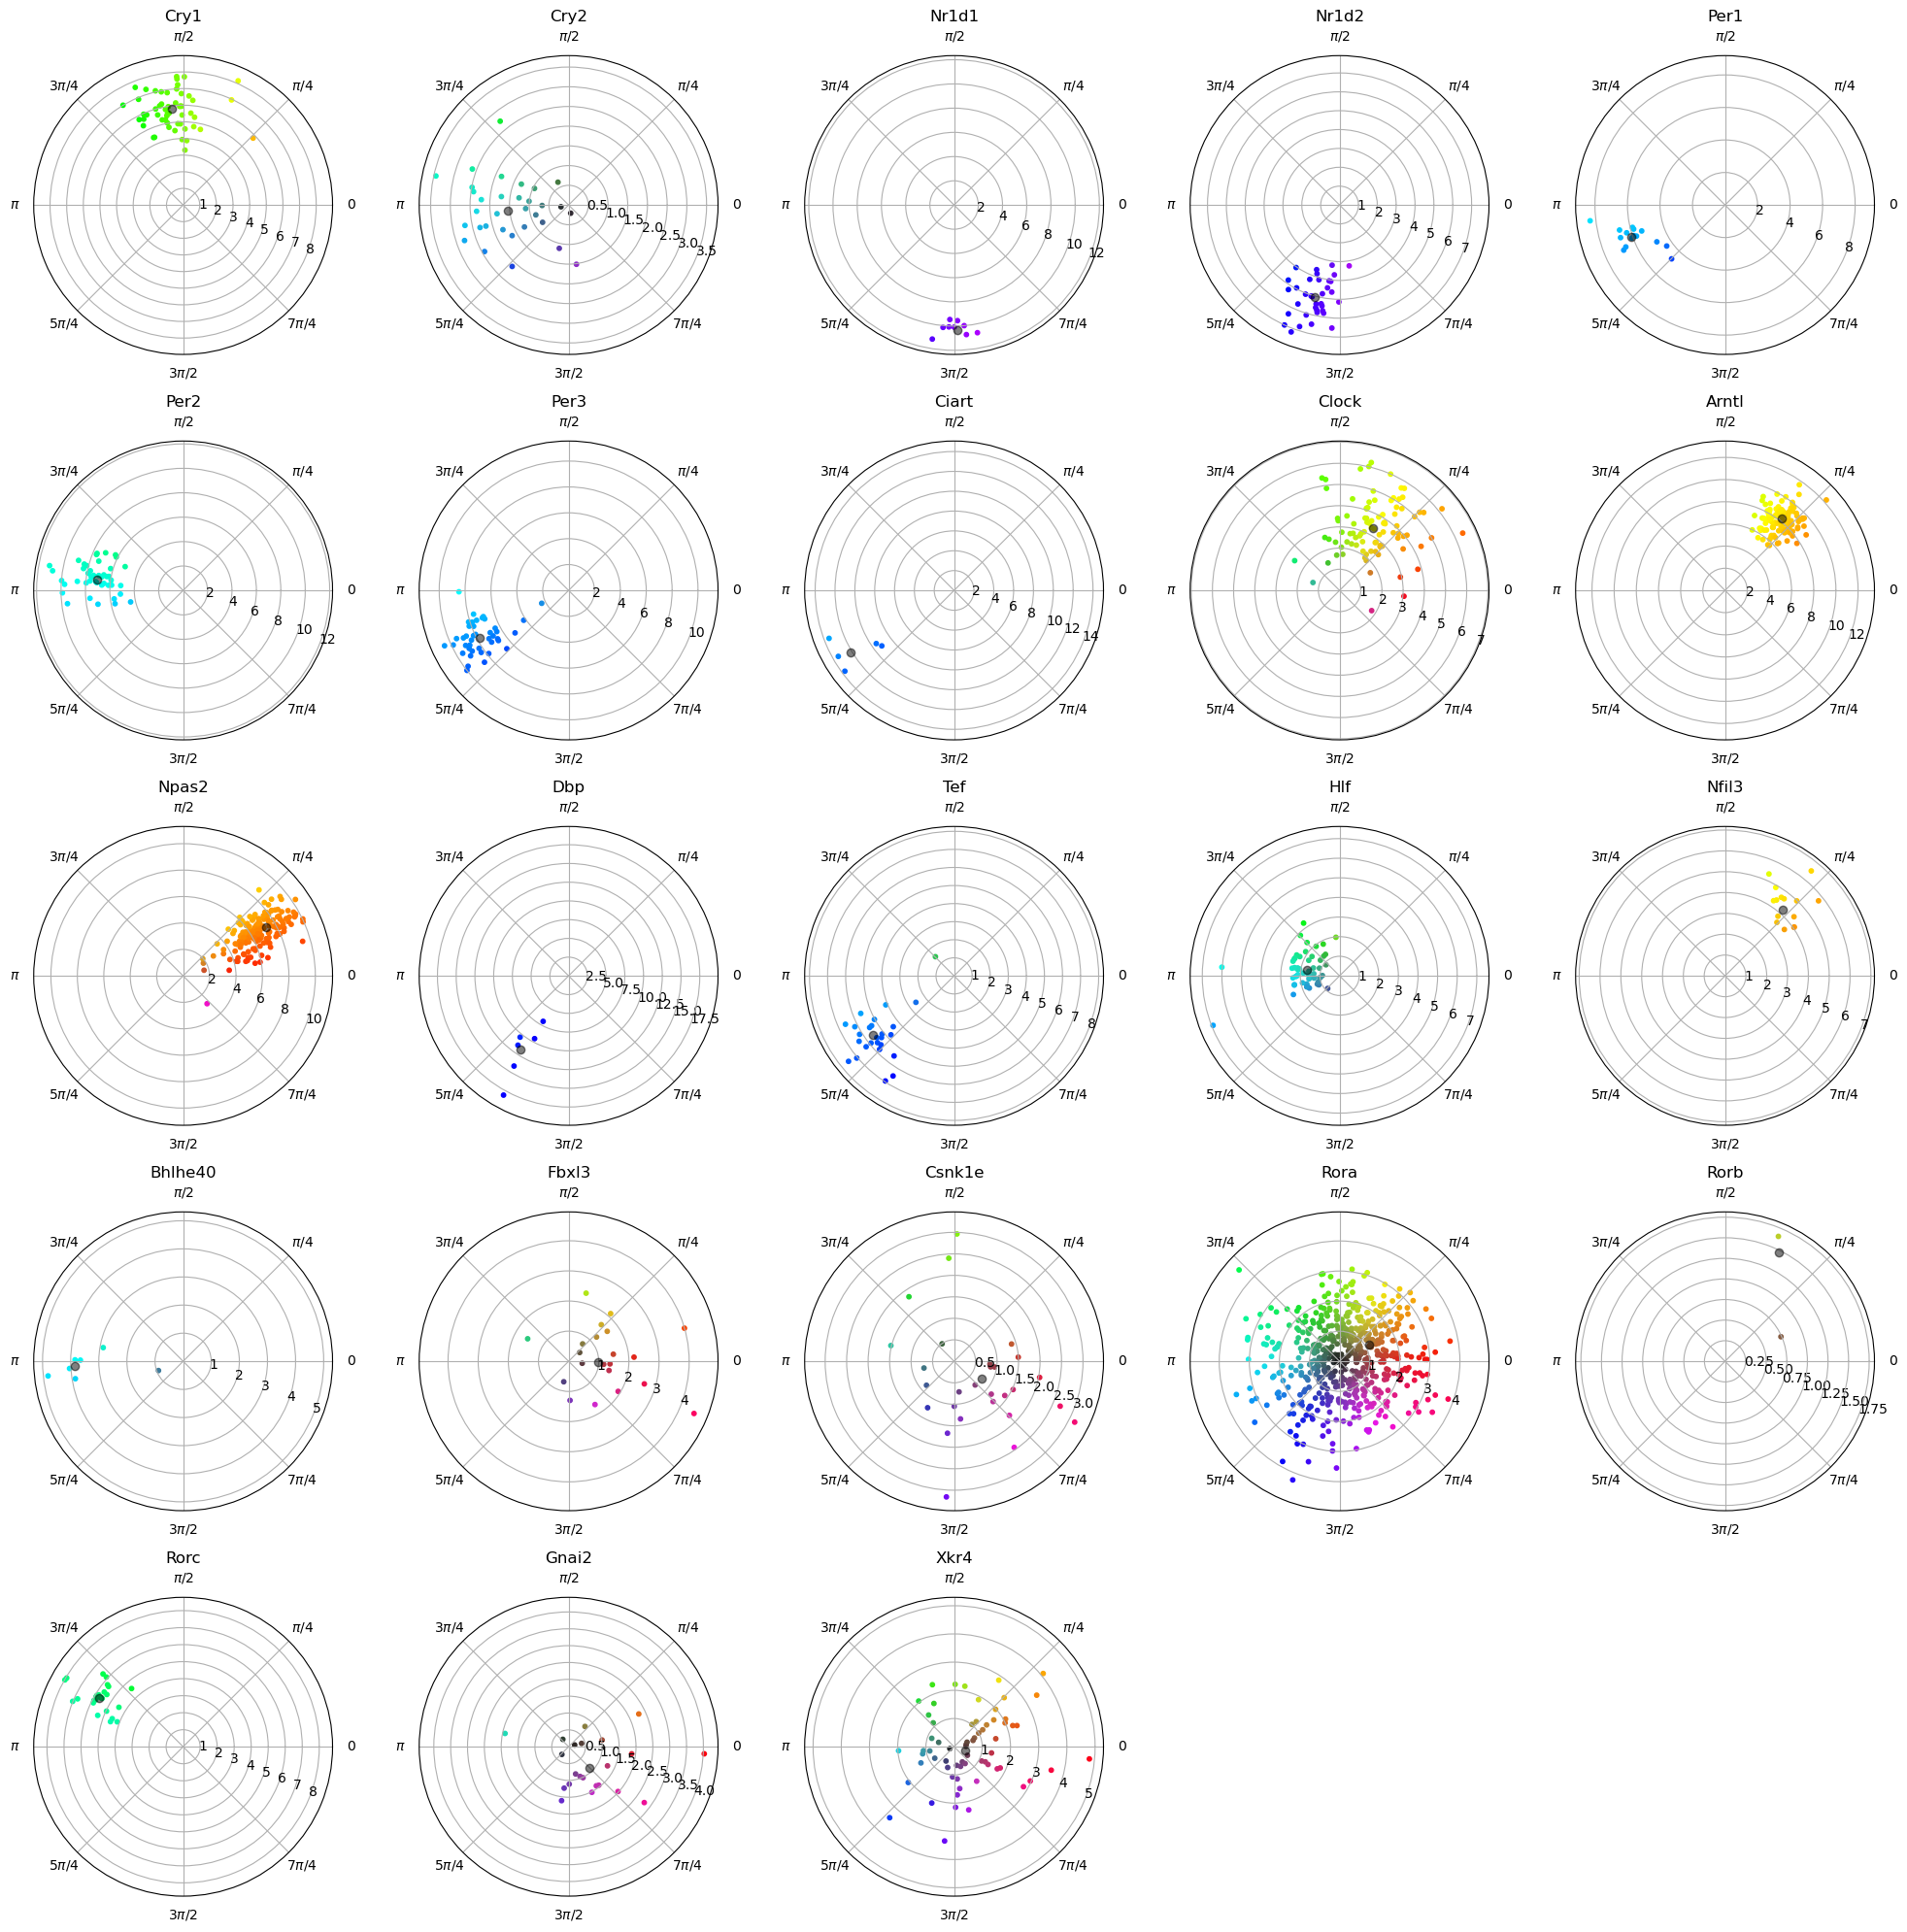

In [103]:
data_folder='../results/binned_norm_counts/'
Samples = [f'PRO_SEQ_CT{4*i:02d}_S{i+1}_R1_001' for i in range(12)]
Strands = ['forward','reverse']
bin_size = 1000
T = np.arange(0,48,4)

# awk '$3=="gene"' resources/genome/GRCm39/gencode.vM33.primary_assembly.annotation.gtf | grep "^chr" > resources/genome/GRCm39/gene.gtf
gtf = pd.read_csv('../resources/genome/GRCm39/gene.gtf',sep='\t',header=None)
gtf.columns = ['chr','source','type','start','end','score','strand','frame','attribute']
gtf['gene_name'] = gtf.attribute.str.extract(r'gene_name "(.*?)";')

f = {}
for sample in Samples:
    t = int(sample.split('_')[2][2:])
    f[t] = {}
    for strand in Strands:
        if strand=='forward':
            f[t]['+'] = bw.open(f"{data_folder}/{sample}/NormCoverage_3p_{strand}_bin{bin_size}bp.bw")
        elif strand=='reverse':
            f[t]['-'] = bw.open(f"{data_folder}/{sample}/NormCoverage_3p_{strand}_bin{bin_size}bp.bw")

Genes = ["Cry1","Cry2","Nr1d1","Nr1d2","Per1","Per2","Per3","Ciart","Clock","Arntl","Npas2","Dbp","Tef","Hlf","Nfil3","Bhlhe40","Fbxl3","Csnk1e","Rora","Rorb","Rorc","Gnai2","Xkr4"]
n_col = int(np.ceil(np.sqrt(len(Genes))))
n_row = int(np.ceil(len(Genes)/n_col))
fig = plt.figure(figsize=(n_col*4,n_row*4))
for g, gene in enumerate(Genes):
    print(gene)

    coord = gtf.loc[gtf.gene_name==gene,['chr','start','end','strand']]
    chr = coord.chr.values[0]
    start = coord.start.values[0]
    end = coord.end.values[0]
    strand = coord.strand.values[0]

    Bins = np.arange(start - start%bin_size,end + bin_size - end%bin_size,bin_size)

    X = np.zeros((len(Bins),len(T)))
    X[:] = np.nan
    df = pd.DataFrame(X,index=Bins,columns=T)

    for t in T:
        vals = f[t][strand].intervals(chr,start,end)
        if vals is None:
            df.loc[:,t] = np.nan
            continue

        bins = [vals[i][0] for i in range(len(vals))]
        counts = [vals[i][2] for i in range(len(vals))]
        df.loc[bins,t] = counts

    idx_out = np.isnan(df.values).sum(1) > .8*T.shape[0]
    df = df.loc[~idx_out,:]
    df[np.isnan(df.values)] = 0

    X = np.log(df.values + 1/bin_size)
    w = df.values.sum(1)
    w = w/w.sum()
    alpha = 0.8*(w/np.max(w)) + .1

    # fourier transform
    for n in range(1,2):
        f_n = np.sum(X*np.exp(-1j*2*n*np.pi*T/24),1)
        a_n = np.abs(f_n)
        phi_n = np.angle(f_n)

        f_m = np.sum(f_n*w)
        a = np.abs(f_m)
        phi = np.angle(f_m)

    # get color
    color = len(phi_n)*[(0,0,0)]
    for i,p in enumerate(phi_n):
        # normalize phase and amplitude in [0,1]
        h = (p % (2*np.pi))/(2*np.pi)
        s = 1 - np.exp(-a_n[i])
        v = 1 - np.exp(-a_n[i])
        color[i] = hsv_to_rgb(h,s,v)

    # plot in polar coordinates
    ax = fig.add_subplot(n_row,n_col,g+1,projection='polar')
    ax.scatter(phi_n,a_n,s=10,marker='o',c=color)
    ax.plot(phi,a,'o',color='k',alpha=0.5)
    ax.set_rmax(1.1*np.max(a_n))
    ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
    ax.set_xticks(np.arange(0,2*np.pi,np.pi/4))
    ax.set_xticklabels([r'0',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$',r'$5\pi/4$',r'$3\pi/2$',r'$7\pi/4$'])
    ax.grid(True)
    ax.set_title(gene)

plt.tight_layout()
plt.savefig('../results/fig/gene_phase_amp.pdf')



In [3]:
bed = pd.read_csv('../results/binned_norm_counts/gene_phase.bed',sep='\t',header=None)
bed[4] = 500
bed[4] = bed[4].astype('int64')
bed.dtypes
bed.to_csv('../results/binned_norm_counts/gene_phase.bed',sep='\t',header=None,index=False)

In [21]:
bed

,0,1,2,3,4,5,6,7,8,9,10,11
0,chr1,3143476,3144545,4933401J01Rik,0,+,3143476,3144545,"0,0,0",1,1069,0
1,chr1,3172239,3172348,Gm26206,0,+,3172239,3172348,"155,120,60",1,109,0
2,chr1,3276124,3741721,Xkr4,2,-,3276124,3741721,"87,57,65",1,465597,0
3,chr1,3322980,3323459,Gm18956,0,+,3322980,3323459,"0,0,0",1,479,0
4,chr1,3435954,3438772,Gm37180,0,-,3435954,3438772,"0,0,0",1,2818,0
...,...,...,...,...,...,...,...,...,...,...,...,...
56879,chrY,90676615,90678894,Gm28301,0,-,90676615,90678894,"0,0,0",1,2279,0
56880,chrY,90763696,90766736,Gm21860,0,-,90763696,90766736,"207,38,173",1,3040,0
56881,chrY,90764326,90774754,Mid1-ps1,3,+,90764326,90774754,"110,193,46",1,10428,0
56882,chrY,90796007,90827734,Gm47283,26,+,90796007,90827734,"70,126,63",1,31727,0


In [14]:
bed

,0,1,2,3,4,5,6,7,8,9,10,11
0,chr1,3143476,3144545,4933401J01Rik,0.0,+,3143476,3144545,"0,0,0",1,1069,0
1,chr1,3172239,3172348,Gm26206,0.0,+,3172239,3172348,"155,120,60",1,109,0
2,chr1,3276124,3741721,Xkr4,2.0,-,3276124,3741721,"87,57,65",1,465597,0
3,chr1,3322980,3323459,Gm18956,0.0,+,3322980,3323459,"0,0,0",1,479,0
4,chr1,3435954,3438772,Gm37180,0.0,-,3435954,3438772,"0,0,0",1,2818,0
...,...,...,...,...,...,...,...,...,...,...,...,...
56879,chrY,90676615,90678894,Gm28301,0.0,-,90676615,90678894,"0,0,0",1,2279,0
56880,chrY,90763696,90766736,Gm21860,0.0,-,90763696,90766736,"207,38,173",1,3040,0
56881,chrY,90764326,90774754,Mid1-ps1,3.0,+,90764326,90774754,"110,193,46",1,10428,0
56882,chrY,90796007,90827734,Gm47283,26.0,+,90796007,90827734,"70,126,63",1,31727,0
